# Options sur devises

In [164]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Simulation de trajectoires sous la probabilité risque neutre

In [165]:
class BlackScholes:
    """
    Simulates asset price paths under the Black-Scholes model.

    Parameters
    ----------
    mu : float
        The drift (expected return) of the asset.
    sigma : float
        The volatility of the asset.
    """

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def generate(self, x, T, N, n):
        """
        Generate simulated price paths using the discrete-time Black-Scholes model.

        Parameters
        ----------
        x : float
            Initial asset price.
        T : float
            Maturity (in years).
        N : int
            Number of time steps.
        n : int
            Number of simulated paths.

        Returns
        -------
        S : ndarray of shape (n, N)
            Simulated asset price trajectories.
        """
        S = np.zeros((n, N))
        S[:, 0] = x
        dt = T / N

        for i in range(1, N):
            S[:, i] = S[:, i-1] + S[:, i-1] * (
                self.mu * dt + self.sigma * np.sqrt(dt) * np.random.randn(n)
            )

        return S

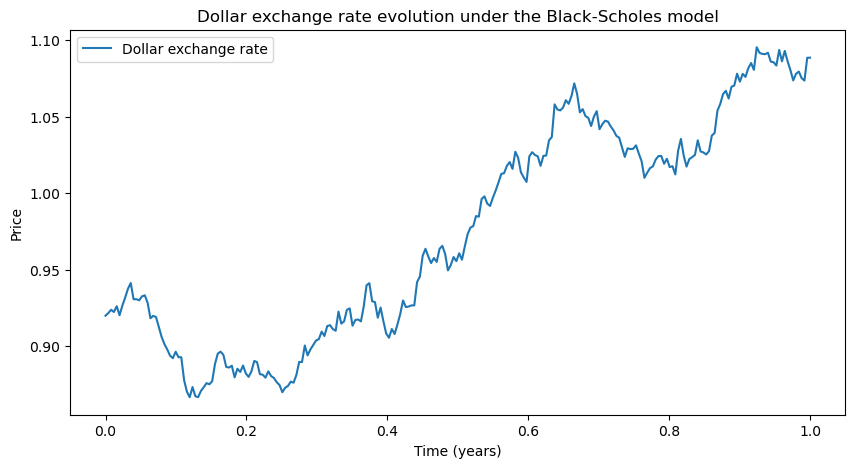

In [166]:
# Paramètres
S0 = 0.92         # Taux de change initial (ex: 1 USD = 0.92 EUR)
sigma = 0.10      # Volatilité
mu = 0.08         # Drift réel (non utilisé pour pricing sous neutre risque)
r0 = 0.03         # Taux domestique (France, en EUR)
r1 = 0.07         # Taux étranger (USA, en USD)
T = 1             # Maturité en années
N = 252           # Nombre de pas de temps (jours ouvrés)
dt = T / N        # Pas de temps
n = 1             # Nombre de trajectoires simulées

# Création du modèle Black-Scholes
model = BlackScholes(mu, sigma)

# Simulation des trajectoires
trajectory = model.generate(S0, T, N, n)

# Grille de temps
time_grid = np.linspace(0, T, N)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_grid, trajectory[0], label='Dollar exchange rate')
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.title("Dollar exchange rate evolution under the Black-Scholes model")
plt.legend()
plt.savefig("cours-dollar.png")
plt.show()

## Prix et Delta

In [167]:
def option_prices(trajectories, T, N, K, r0, r1, sigma):
    """
    Computes the price of a European call option at each time step for multiple simulated asset paths
    under the Black-Scholes model.

    Parameters
    ----------
    trajectories : ndarray of shape (n, N)
        Simulated asset price trajectories, where `n` is the number of paths and `N` is the number of time steps.
    T : float
        Maturity of the option (in years).
    N : int
        Number of time steps.
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate.
    sigma : float
        Volatility of the underlying asset.

    Returns
    -------
    p : ndarray of shape (n, N)
        Theoretical European call option prices at each time step and for each trajectory.
    """
    n = trajectories.shape[0]
    dt = T / N
    time_grid = np.linspace(0, T, N)
    p = np.zeros((n, N))

    for i in range(N - 1):
        tau = T - time_grid[i]
        S_t = trajectories[:, i]

        d1_val = (np.log(S_t / K) + (r0-r1 + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
        d2_val = d1_val - sigma * np.sqrt(tau)

        p[:, i] = np.exp(-r1 * tau) * S_t * norm.cdf(d1_val) - K * np.exp(-r0 * tau) * norm.cdf(d2_val)

    # Final value at maturity: option payoff
    p[:, -1] = np.maximum(trajectories[:, -1] - K, 0)

    return p

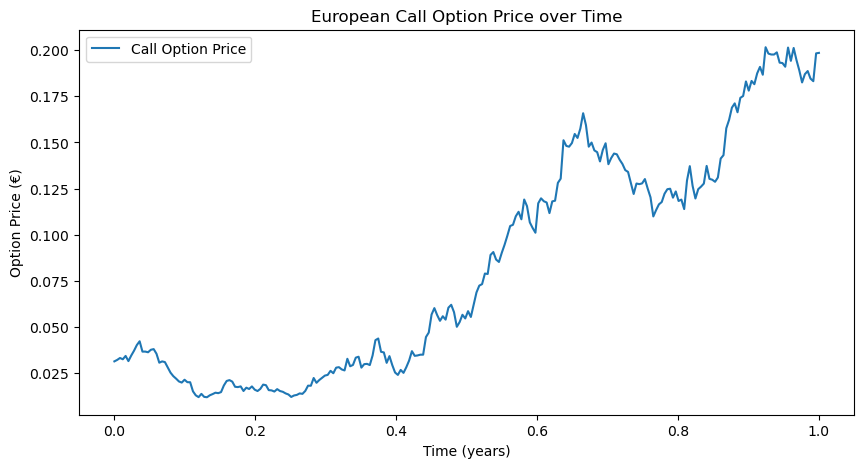

In [168]:
# Calcul des prix
prices = option_prices(trajectory, T, N, K, r0, r1, sigma)[0, :]

# Affichage du prix de l’option
plt.figure(figsize=(10, 5))
plt.plot(time_grid, prices, label='Call Option Price')
plt.xlabel("Time (years)")
plt.ylabel("Option Price (€)")
plt.title("European Call Option Price over Time")
plt.legend()
plt.show()

# Couverture

In [169]:
def d_plus(tau, x, T, K, r0, r1, sigma):
    d = (x*np.exp(-r1*tau))/(K*np.exp(-r0*tau))
    d = np.log(d) / (sigma * np.sqrt(tau))
    d += sigma * np.sqrt(tau) / 2
    return d

In [170]:
def hedging(trajectories, C0, T, N, K, r0, r1, sigma):
    n = trajectories.shape[0]
    dt = T / N

    H0 = np.zeros((n, N))  # Cash
    H = np.zeros((n, N))   # Delta (asset holding)
    V = np.zeros((n, N))   # Total value of the portfolio

    time_grid = np.linspace(0, T, N)
    tau_grid = T - time_grid
    tau_grid[N - 1] += 1e-4  # Avoid division by zero at maturity

    # Initial hedge at time t = 0
    tau = tau_grid[0]
    d1_0 = d_plus(tau, trajectories[:, 0], T, K, r0, r1, sigma)
    H[:, 0] = norm.cdf(d1_0)
    H0[:, 0] = C0 - H[:, 0] * trajectories[:, 0]
    V[:, 0] = H[:, 0] * trajectories[:, 0] + H0[:, 0]

    for i in range(1, N):
        tau = tau_grid[i]
        S_i = trajectories[:, i]

        H0[:, i] = H0[:, i - 1] * np.exp(r0 * dt)
        h = H[:, i - 1] * np.exp(r1 * dt)

        dplus_i = d_plus(tau, S_i, T, K, r0, r1, sigma)
        H[:, i] = norm.cdf(dplus_i)

        H0[:, i] -= (H[:, i] - h) * S_i

        V[:, i] = H[:, i] * S_i + H0[:, i]

    return H0, H, V

In [171]:
(H0, H, val) = hedging(trajectory, prices[0], T, N, K, r0, r1, sigma)

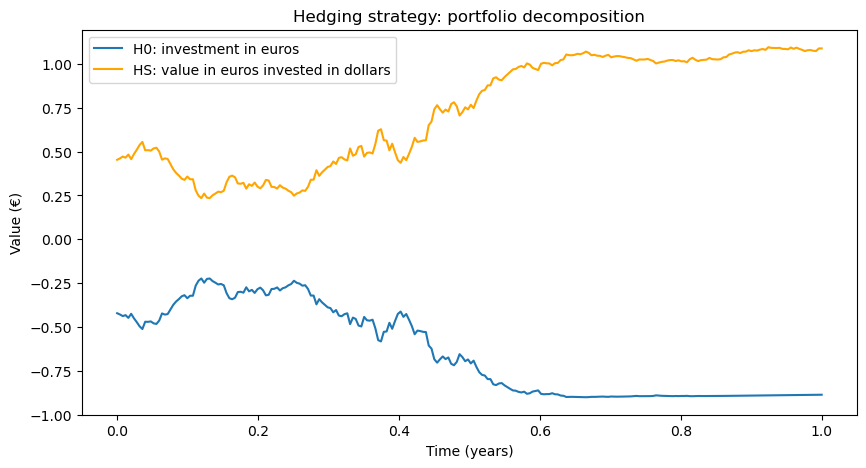

In [172]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, H0[0], label='H0: investment in euros')
plt.plot(time_grid, H[0] * trajectory[0], label='HS: value in euros invested in dollars', color='orange')
plt.xlabel("Time (years)")
plt.ylabel("Value (€)")
plt.title("Hedging strategy: portfolio decomposition")
plt.legend()
plt.savefig("positions-couverture.png")
plt.show()

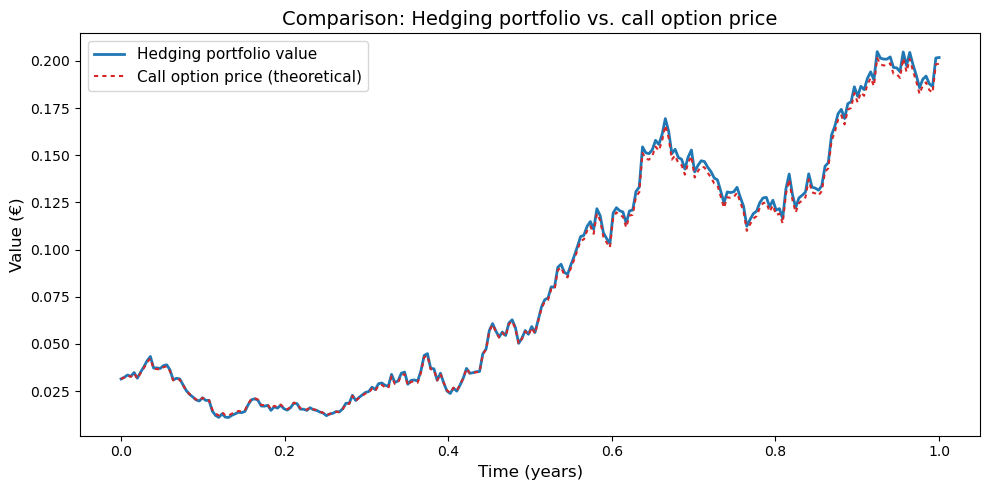

In [173]:
plt.figure(figsize=(10, 5))

# Tracé principal
plt.plot(time_grid, val[0], label='Hedging portfolio value', color='#1f77b4', linewidth=2)

# Tracé pointillé plus fin et resserré
plt.plot(time_grid, prices, label='Call option price (theoretical)',
         color='#d62728', linewidth=1.5, dashes=(2, 2))  # 2pt trait, 2pt espace

# Titres et axes
plt.title("Comparison: Hedging portfolio vs. call option price", fontsize=14)
plt.xlabel("Time (years)", fontsize=12)
plt.ylabel("Value (€)", fontsize=12)

# Légende et grille
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("valeur-couverture-option.png")
plt.show()

## Exercice de couverture

In [174]:
def risk(T, N, n_simul, mu, sigma, x, K, r0, r1):
    """
    Computes the hedging error for a European call option using a delta hedging strategy
    under the Black-Scholes model.

    Parameters
    ----------
    T : float
        Maturity of the option (in years).
    N : int
        Number of time steps.
    n_simul : int
        Number of simulated asset price trajectories.
    mu : float
        Drift (expected return) of the asset.
    sigma : float
        Volatility of the asset.
    x : float
        Initial asset price.
    K : float
        Strike price of the European call option.
    r : float
        Risk-free interest rate.

    Returns
    -------
    R : ndarray of shape (n_simul,)
        Hedging error at maturity for each simulated path, defined as:
        portfolio value - option payoff.
    """
    model = BlackScholes(mu, sigma)

    # Simulate asset price trajectories
    trajectories = model.generate(x, T, N, n_simul)

    # Compute the theoretical call price along each trajectory
    C_all = option_prices(trajectories, T, N, K, r0, r1, sigma)

    # Get the initial option price for each path
    C0 = C_all[:, 0]

    # Perform delta hedging for each path
    H0, H, V = hedging(trajectories, C0, T, N, K, r0, r1, sigma)

    # Compute payoff of the European call at maturity
    payoff = np.maximum(trajectories[:, -1] - K, 0)

    # Hedging error: difference between hedged portfolio and actual payoff
    R = V[:, -1] - payoff

    return R

In [175]:
n_simul = 10000
R = risk(T, N, n_simul, mu, sigma, S0, K, r0, r1)

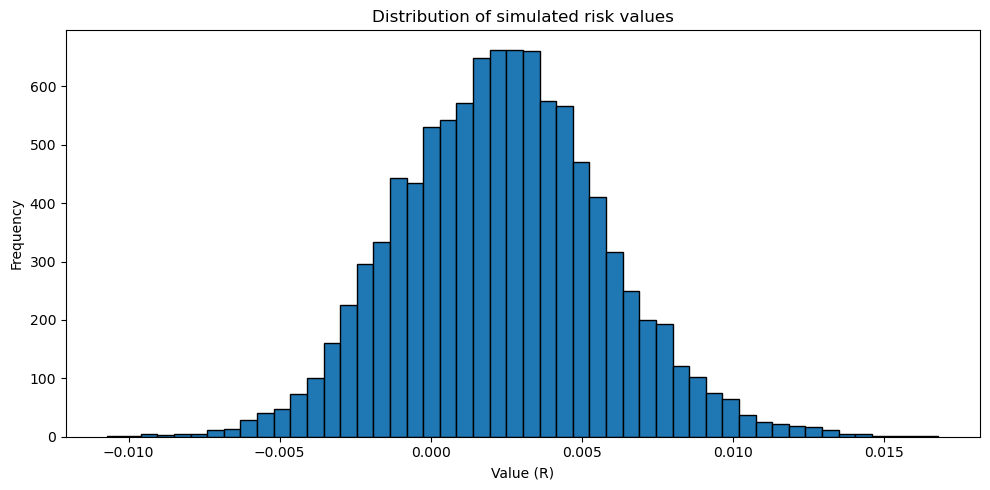

In [176]:
plt.figure(figsize=(10, 5))
plt.hist(R, bins=50, edgecolor='black')
plt.title("Distribution of simulated risk values")
plt.xlabel("Value (R)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("risk-distribution.png")
plt.show()

In [177]:
N_values = [4, 6, 12, 52, 252, 1638]

n_simul = 10000

R_squared_means = np.zeros(len(N_values))

for i, N in enumerate(N_values):
    R_simul = risk(T, N, n_simul, mu, sigma, S0, K, r0, r1)
    R_squared_means[i] = np.mean(R_simul**2)

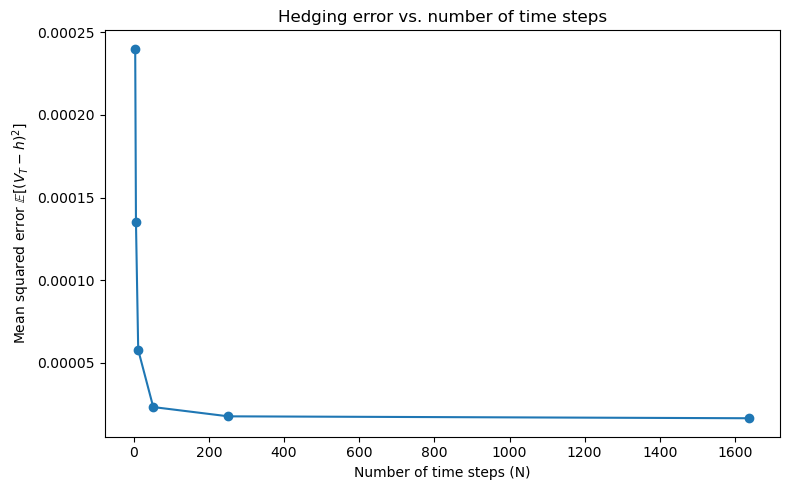

In [178]:
plt.figure(figsize=(8, 5))
plt.plot(N_values, R_squared_means, marker='o')

plt.xlabel("Number of time steps (N)")
plt.ylabel("Mean squared error $\\mathbb{E}[(V_T - h)^2]$")
plt.title("Hedging error vs. number of time steps")

plt.tight_layout()
plt.savefig("erreur.png")
plt.show()

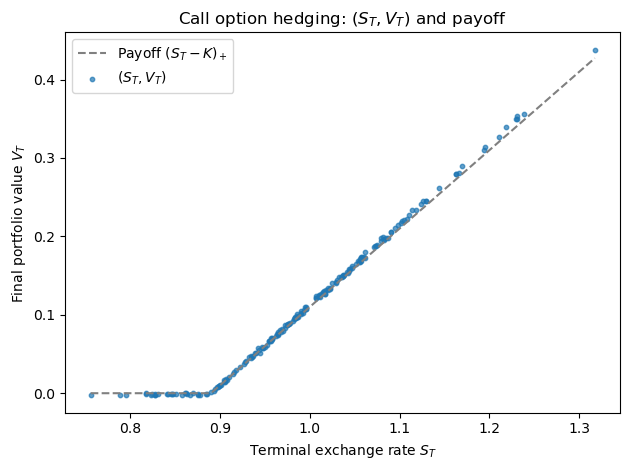

In [179]:
n_points = 200

model = BlackScholes(mu, sigma)
trajectories = model.generate(S0, T, N, n_points)

(H0, H, val) = hedging(trajectories, prices[0], T, N, K, r0, r1, sigma)

# Retrieve terminal values
S_T = trajectories[:, -1]
V_T = val[:, -1]

# Plot theoretical payoff (first so it stays in the background)
x_vals = np.linspace(min(S_T), max(S_T), 200)
payoff = np.maximum(0, x_vals - K)
plt.plot(x_vals, payoff, color='gray', linestyle='--', label='Payoff $(S_T - K)_+$')

# Plot (S_T, V_T) points
plt.scatter(S_T, V_T, alpha=0.7, s=10, label='$(S_T, V_T)$')

# Labels and title
plt.xlabel("Terminal exchange rate $S_T$")
plt.ylabel("Final portfolio value $V_T$")
plt.title("Call option hedging: $(S_T, V_T)$ and payoff")

plt.legend()
plt.tight_layout()
plt.savefig("exercice-couverture.png")
plt.show()
